In [127]:
import shutil,os,string
import numpy as np
from IPython.display import HTML 
HTML('../style/course.css')
HTML('../style/code_toggle.html')
import matplotlib.pyplot as ppl
from subprocess import *
from astropy.io import fits

def Run(command,verb1=1,verb2=0):
    if verb1: print command
    result=string.split(Popen(string.split(command),stdout=PIPE).communicate()[0],'\n')
    if verb2:
        for jj in result: print jj
    return result

# Continuum subtraction

The analysis and interpretation of spectral-line data is greatly simplified if all sources of continuum emission have already been removed from the data. This chapter describes the methods that can be used to subtract radio continuum emission from visibility datasets or datacubes, resulting in data that contain spectral-line emission and/or absorption only. Here we will adopt the following notation:
- $S(l,m,\nu)$ is the sky brightness as a function of position (relative to a reference position $l_0,m_0$, which we assume to be both the pointing and phase-tracking centre) and frequency;
- $A(l,m,\nu)$ is the primary beam pattern;
- $I(l,m,\nu) = S(l,m,\nu) \cdot A(l,m,\nu)$ is the apparent sky brightness;
- $B(l,m,\nu)$ is the point spread function or PSF;
- $I^\mathrm{D}(l,m,\nu)$ is the dirty cube obtained by convolving $I(l,m,\nu)$ with $B(l,m,\nu)$;
- $\mathbf{b}_{ij}$ is the baseline between antennas $i$ and $j$
- $V_{ij}(t,\nu)$ is the complex visibility for the baseline $\mathbf{b}_{ij}$ at time $t$ and frequency $\nu$; this notation is preferred to the more common $V_{\nu}(u,v)$ because for a given visibility spectrum $V_{ij}(t,\nu)$ the coordinates $u$ and $v$ change with frequency (we will see that this is relevant for continuum subtraction);
- cubes and visibilities are composed of a continuum and a spectral line term, e.g., $I(l,m,\nu) = I_\mathrm{c}(l,m,\nu) + I_\mathrm{s}(l,m,\nu)$ and $V_{ij}(t,\nu) = V_{ij,\mathrm{c}}(t,\nu) + V_{ij,\mathrm{s}}(t,\nu)$.

## Outline

**1.** <a href="http://localhost:8888/notebooks/contsub.ipynb#1.-Overview-of-continuum-subtraction-methods">Overview of continuum subtraction methods</a>

**2.** <a href="http://localhost:8888/notebooks/contsub.ipynb#2.-Cube-based-continuum-subtraction">Cube-based continuum subtraction</a>

**3.** <a href="http://localhost:8888/notebooks/contsub.ipynb#3.-Visibility-based-continuum-subtraction">Visibility-based continuum subtraction</a>

**4.** <a href="http://localhost:8888/notebooks/contsub.ipynb#4.-Model-based-continuum-subtraction">Model-based continuum subtraction</a>



## 1. Overview of continuum subtraction methods

Continuum emission can be removed from interferometric data in a variety of ways, which can be grouped under the following 3 categories:
- *cube based*, where the continuum emission is estimated and subtracted from a dirty cube $I^\mathrm{D}(l,m,\nu)$ or, under some circumstances, a deconvolved cube $I(l,m,\nu)$ -- Sec. 2;
- *visibility based*, where the continuum emission is estimated and subtracted from visibility spectra $V_{ij}(t,\nu)$ -- Sec. 3;
- *model based*, wheren the continuum emission $I_\mathrm{c}(l,m,\nu)$ is modelled from a continuum (possibly multi-frequency) image, and the model is Fourier transformed and subtracted from the visibilities $V_{ij}(t,\nu)$ -- Sec. 4.

Each method has advantages and disadgantages, and often it is advisiable to use more than one method to completely remove continuum emission from the data (Sec. 5). As usual, simpler methods are faster but may be less accurate. Important factors affecting their performance include:
- the fractional bandwidth over which one needs to subtract the continuum
- the quality of the calibration
- the distance of the continuum sources from the phase centre
- the brightness of the spectral line relative to the continuum

Below we describe these different methods, their advantages and disadvantages, and how the above factors come into play.

## 2. Cube-based continuum subtraction

### 2.1. Basic method

If no continuum has been subtracted from the visibilities $V_{ij}(t,\nu)$, each sightline ($l,m$) of the dirty cube $I^\mathrm{D}(l,m,\nu)$ will in principle include some level of continuum emission $I^\mathrm{D}_\mathrm{c}(l,m,\nu)\ne0$. This includes both emission at the position of real continuum sources and emission corresponding to their PSF sidelobes. The sidelobes contribution would disappear if one could deconvolve the cube before subtracting the continuum. However, this is ususally not advisable and, for the moment, we assume that the cube is dirty. We will return to the point of deconvolution in Sec. 2.3.

The basic idea of this method is to estimate and remove the continuum component $I^\mathrm{D}_\mathrm{c}(l,m,\nu)$ of the dirty cube along each sightline ($l,m$) independently. This can be done by modelling it with a low order polynomial; that is, fit and subtract $I^\mathrm{D}_\mathrm{c,model}(l,m,\nu)=\sum_{n=0}^{N} a_n(l,m)\ \nu^n$ to the line-free channels. In general, for smaller fractional bandwidths the variation of $I^\mathrm{D}_\mathrm{c}(l,m,\nu)$ with frequency is more limited and, therefore, the order $N$ of the polynomial can be smaller. The limiting case is one where it is sufficient to take the average of all line-free channels (or a $0^\mathrm{th}$-order polynomial fit) as an estimate of a frequency-independent continuum.

### 2.2. Limitations

For a correct choice of $N$, note that the variation of $I^\mathrm{D}_\mathrm{c}(l,m,\nu)$ with frequency is determined not only by the intrinsic continuum spectrum of the sky $S_\mathrm{c}(l,m,\nu)$ but also by the variation of the primary beam $A(l,m,\nu)$ with frequency. The latter is a decreasing function of frequency (within the main lobe) and, therefore, it has the effect of decreasing the spectral slope of the observed sources. Because of such primary beam modulation, two identical sources at different positions within the primary beam will in general have different observed spectral shapes. The order of the polynomial will need to be chosen to deal with the "worst" source in the field.

An additional effect to consider is that of the PSF. At a position of the cube where most of the continuum flux comes from the sidelobes of a nearby source, the observed flux density variation with frequency depends critically on the structure of the PSF $B(l,m,\nu)$ and its variation with frequency (which, besides the standard scaling with frequency, may be in part due to frequency-dependent flagging). The resulting frequency dependence of $I^\mathrm{D}_\mathrm{c}(l,m,\nu)$ can be more complex than that at the position of a real continuum source. This means that even when a low-$N$ approximation is valid for a source it may be inaccurate for its sidelobes. In other words, this method of continuum subtraction results in an error which depends on the distance from the continuum source being subtracted as well as on the 3D PSF pattern $B(l,m,\nu)$. Cornwell, Uson & Addad (1992) give a formal discussion of this error for the case in which the continuum sources have a spectrum which is a linear function of frequency. Clearly, this error is lower for a lower PSF sidelobe level and/or a smaller PSF variation with frequency (e.g., because of a low fractional bandwidth).

Note that in cubes made with MIRIAD the pixel size scales with $1/\nu$ and, therefore, the PSF pattern does not change with frequency in the $(x,y,z)$ cube pixel grid. Therefore, for a source close to the image centre the aforementioned error is much less of an issue. Far from the image centre, however, this scaling means that sources move radially in $(x,y)$ as the frequency changes. This complicates their cube-based continuum subtraction, which is done at fixed $(x,y)$. In other words, MIRIAD's "trick" of varying the pixel size with frequency reduces the continuum subtraction error as a function of distance from a continuum source but introduces a new error which depends on the distance from the image centre. We will see that also the visibility-based continuum subtraction is characterized by a similar type of error (Sec. 3).

Below we show an ideal example of this method by simulating a visibility dataset in MIRIAD. The visibilities are recorded for an east-west array with baselines between 200 m and 2 km. The sky model is made of a single, 1 Jy point source with a flat spectrum and located at the phase centre. The observing frequency is 1.4 GHz and the bandwidth is 100 MHz (7% fractional bandwidth). The observed band is sampled with 256 channels. No noise is included, and the observation consists of a full 12-h track from HA = -6 h to HA = +6 h.

In [233]:
print '# Executing MIRIAD commands'
simuv='sim01.uv'
if os.path.exists(simuv): shutil.rmtree(simuv)
run_uvgen=Run('uvgen source=pointsource01.txt ant=ew_layout.txt baseunit=-51.0204 radec=19:39:25.0,-83:42:46 freq=1.4,0 corr=256,1,0,100 out=%s harange=-6,6,0.016667 systemp=0 lat=-30.7 jyperk=19.28'%(simuv))
print '# Done'

# Executing MIRIAD commands
uvgen source=pointsource01.txt ant=ew_layout.txt baseunit=-51.0204 radec=19:39:25.0,-83:42:46 freq=1.4,0 corr=256,1,0,100 out=sim01.uv harange=-6,6,0.016667 systemp=0 lat=-30.7 jyperk=19.28
# Done


We create a datacube from the visibilities, and use MIRIAD's REGRID to remove the aforementioned pixel size scaling with frequency of the cube.

In [234]:
print '# Executing MIRIAD commands'
image='m'
image_noscale='m_ns'
if os.path.exists(image): shutil.rmtree(image)
if os.path.exists(image_noscale): shutil.rmtree(image_noscale)
run_invert=Run('invert vis=%s map=%s imsize=512 cell=5 slop=1 robust=0'%(simuv,image))
run_regrid=Run('regrid in=%s out=%s options=noscale'%(image,image_noscale))
run_fits=Run('fits in=%s op=xyout out=%s.fits'%(image_noscale,image_noscale))
print '# Done'

# Executing MIRIAD commands
invert vis=sim01.uv map=m imsize=512 cell=5 slop=1 robust=0
regrid in=m out=m_ns options=noscale
fits in=m_ns op=xyout out=m_ns.fits
# Done


The regridded cube can be visualised to show that the PSF sidelobes move significantly on the sky when going from one end to the other of the 7% fractional bandwidth.

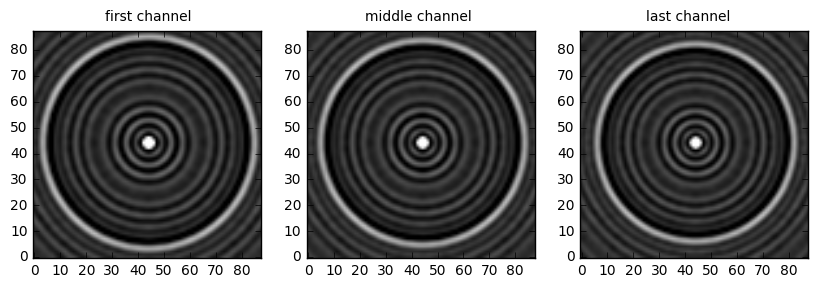

In [223]:
f=fits.open('%s.fits'%image_noscale)
cube=f[0].data[0]
f.close()

ppl.figure(figsize=(10,5))
#ppl.subplots_adjust(wspace=0.4,hspace=0.45)
ppl.subplot(131)
ppl.imshow(cube[0,212:300,212:300],origin='lower',cmap='gray',vmin=-0.05,vmax=0.2)
ppl.subplot(132)
ppl.imshow(cube[128,212:300,212:300],origin='lower',cmap='gray',vmin=-0.05,vmax=0.2)
ppl.subplot(133)
ppl.imshow(cube[-1,212:300,212:300],origin='lower',cmap='gray',vmin=-0.05,vmax=0.2)
ppl.figtext(0.24,0.76,'first channel',ha='center')
ppl.figtext(0.51,0.76,'middle channel',ha='center')
ppl.figtext(0.78,0.76,'last channel',ha='center')
ppl.show()

As exaplained above, this change in the sidelobes' position on the sky with frequency means that a cube-based continuum subtraction will not work well at the position of the sidelobes. To show this we subtract the continuum from the regridded cube using MIRIAD's CONTSUB and using a range of polynomial orders, and display the same three channels of the continuum subctracted cube on the same grey scale.

In [170]:
print '# Executing MIRIAD commands'
for order in [1,2,3]:
    image_noscale_contsub=image_noscale+'_cs%i'%order
    if os.path.exists(image_noscale_contsub): shutil.rmtree(image_noscale_contsub)
    run_contsub=Run('contsub in=%s, out=%s mode=poly,%i contchan=(1,256)'%(image_noscale,image_noscale_contsub,order))
    run_fits=Run('fits in=%s op=xyout out=%s.fits'%(image_noscale_contsub,image_noscale_contsub))

print '# Done'

contsub in=m_ns, out=m_ns_cs1 mode=poly,1 contchan=(1,256)
fits in=m_ns_cs1 op=xyout out=m_ns_cs1.fits
contsub in=m_ns, out=m_ns_cs2 mode=poly,2 contchan=(1,256)
fits in=m_ns_cs2 op=xyout out=m_ns_cs2.fits
contsub in=m_ns, out=m_ns_cs3 mode=poly,3 contchan=(1,256)
fits in=m_ns_cs3 op=xyout out=m_ns_cs3.fits
# Done


# Plotting m_ns_cs1.fits
# Plotting m_ns_cs2.fits
# Plotting m_ns_cs3.fits


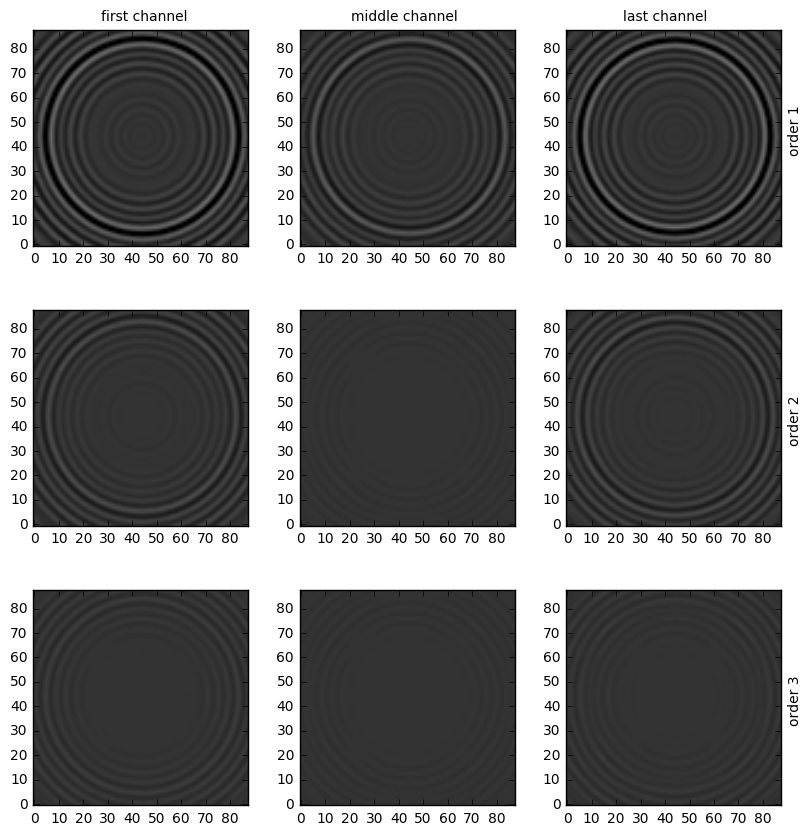

In [221]:
ppl.figure(figsize=(10,10))
ppl.subplots_adjust(wspace=0.1,hspace=0.3)

for order in [1,2,3]:
    image_noscale_contsub=image_noscale+'_cs%i'%order
    print '# Plotting %s.fits'%(image_noscale_contsub)
    f=fits.open('%s.fits'%image_noscale_contsub)
    cube=f[0].data[0]
    f.close()
    ppl.subplot(3,3,(order-1)*3+1)
    ppl.imshow(cube[0,212:300,212:300],origin='lower',cmap='gray',vmin=-0.05,vmax=0.2)
    ppl.subplot(3,3,(order-1)*3+2)
    ppl.imshow(cube[128,212:300,212:300],origin='lower',cmap='gray',vmin=-0.05,vmax=0.2)
    ppl.subplot(3,3,(order-1)*3+3)
    ppl.imshow(cube[-1,212:300,212:300],origin='lower',cmap='gray',vmin=-0.05,vmax=0.2)

ppl.figtext(0.25,0.91,'first channel',ha='center')
ppl.figtext(0.51,0.91,'middle channel',ha='center')
ppl.figtext(0.77,0.91,'last channel',ha='center')
ppl.figtext(0.9,0.80,'order 1',ha='center',va='center',rotation=90)
ppl.figtext(0.9,0.51,'order 2',ha='center',va='center',rotation=90)
ppl.figtext(0.9,0.23,'order 3',ha='center',va='center',rotation=90)
ppl.show()

As expected, for this noise-less ideal case, the cube-based continuum subtraction works perfectly at the position of the flat-spectrum source regardless of the order of the polynomial fit. However, the sidelobe emission is not subtracted well. The quality of the sidelobe continuum subtraction increases with increasing order of the polynomial but some level of residuals will always be present. For N=1 the residual level is between 5 and 10 percent of the source flux density, while this level is about halved for N=3. The impact of these residuals on the scientific goals of an observation depend on the flux density of the sources in the fields and the PSF sidelobe level relative to the other sources of noise and artefacts in the cube.

### 2.3. Channel selection and deconvolved cubes

The selection of line-free (and RFI-free) channels is critical for a correct polynomial fit and continuum subtraction. Since for a dirty cube the PSF spreads any line emission/absorption at a given channel to all spatial pixels of that channel, the line-free channel selection does not depend on position and must be applied to all $(l,m)$. In fact, this selection is not always straightforward when working with a dirty cube. For example, the continuum emission (sources and sidelobes) may be much brighter than the line emission/absorption, and a few iterations of deconvolution and continuum subtraction may be required before the line-free channels are correctly identified.

A natural question is whether, since deconvolution may be required to identify the line-free channels, the cube-based continuum subtraction method could be applied directly to the deconvolved cube $I(l,m,\nu)$. This would have the advantage that the PSF sidelobes of both continuum and spectral-line sources have been removed and, therefore, PSF-related continuum subtraction errors would be minimised. Furthermore, since the line emission/absorption has been deconvolved too, and is now localised to a few small regions within each channel, the line-free channel selection could be made position dependent. This could be easily achieved by including a simple outlier rejection algorithm in the polynomial fit, and would maximise the number of fitted channels along each sightline. (In practice, this is not possible in current implementation of the cube-based continuum subtraction in, e.g., CASA and MIRIAD, but has been tried outside these standard packages.)

A singificant issue with subtracting the continuum from a deconvolved cube $I(l,m,\nu)$ is that deconvolution is non-linear and, therefore, leaves residuals and artefacts which vary from channel to channel. This would be particularly true for bright continuum emission and in the presence of significant calibration errors. The following step of continuum subtraction would not remove these artefacts. The final result may then be worse than one in which continuum subtraction is performed before deconvolution. In other words, continuum subtraction on the dirty cube $I^\mathrm{D}(l,m,\nu)$ is much more robust against calibration errors. For this reason, it may be better to attempt the cube-based continuum subtraction of a deconvolved cube only after the brightest continuum emission has been subtracted with a different method such as those described in Secs. 3 and 4. This combined approach is discussed in Sec. 5.

## 3. Visibility-based continuum subtraction

### 3.1. Basic method

This approach consists of subtracting the continuum emission directly from the visibilities by modelling the continuum component $V_{ij,\mathrm{c}}(t,\nu)$ with a low order polynomial $V_{ij,\mathrm{c,model}}(t,\nu) = \sum_{n=0}^{N} a_{ij,n}(t)\ \nu^n$. This is done separately on the real and imaginary parts of each visibility spectrum.


As for the cube-based continuum subtraction, the polynomial fit should only be run on line-free (and RFI-free) channels but their selection is not always straightforward. The line emission/absorption may be too faint to detect in individual visibility spectra, and a few iterations of continuum subtraction and spectral-line imaging may be required to identify the line-free channels correctly.

Since all spectral line sources in the field contribute to all visibility spectra the line-free channel selection should be identical for all spectra. In fact, spatially-extended spectral line emission may be more significant on short baselines and, therefore, there is scope for a baseline dependent line-free channel selection. This could be easily achieved by including basic outlier rejection in the fit. The same could be useful to reject RFI from the fit. These advanced techniques are however not implemented in standard packages, e.g., CASA and MIRIAD. (**CHECK!!!**)

### 3.2. Limitations

The visibility-based continuum subtraction works only as long as the polynomial approximation for real and imaginary part of $V_{ij,\mathrm{c}}(t,\nu)$ is valid. This approximation becomes progressively worse for larger distances from the phase centre, longer baselines and larger relative bandwidths, as we explain in what follows.

The visibility of a unit point source at distance $\mathbf{s}$ from the phase-tracking centre is:

$V_{ij,\mathrm{c}}(t,\nu) = \cos({2\pi\nu/c \ \mathbf{s}\cdot\mathbf{b}_{ij}}) + i \sin({2\pi\nu/c \ \mathbf{s}\cdot\mathbf{b}_{ij}}$),

where $\mathbf{s}\cdot\mathbf{b}_{ij}$ is a function of time $t$. That is, the variation of both real and imaginary part of $V_{ij,\mathrm{c}}(t,\nu)$ with $\nu$ is represented by a sinusoid whose oscillation rate grows with $\mathbf{s}\cdot\mathbf{b}_{ij}$. When the oscillation is slow, for example because the source is at the phase centre or because the projected baseline is very short, the polynomial approximation is sufficiently good even with order 1 or 2. However, when the oscillation is so fast that the observed bandwidth "sees" something of the order of a sinusoid period the polynomial approximation becomes quite poor. For example, at fixed bandwidth, the larger $\mathbf{s}\cdot\mathbf{b}_{ij}$ (either because of a larger distance $\mathbf{s}$ from the phase centre or because of a longer baseline $\mathbf{b}_{ij}$ -- or both), the faster the sinusoidal variation of real and imaginary part of $V_{ij,\mathrm{c}}(t,\nu)$ with frequency, and the poorer the polynomial approximation. Conversely, at fixed $\mathbf{s}\cdot\mathbf{b}_{ij}$, the larger the bandwidth the larger the portion of the sinusoid that we try to approximate with a polynomial and, therefore, the poorer the approximation.

The following example shows the situation for a 100 MHz bandwidth, projected baseline length of 200 m and 2 km, and distance from the phase centre of 1 arcmin and 10 arcmin.

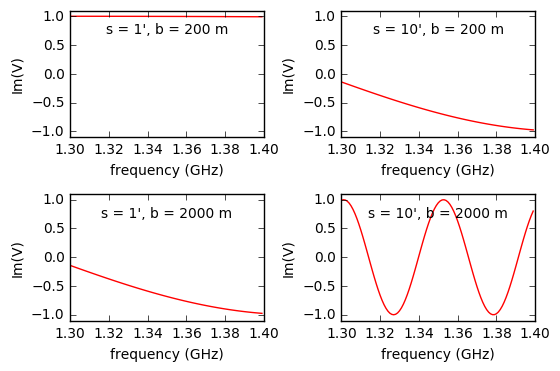

In [194]:
nu=np.arange(1.3,1.4,0.001)*1e+9 # 1-kHz-wide channels over a 100-MHz bandwidth at a frequency of 1.4 GHz
c=2.998e+8
ss=[1.  ,10.  ] # distance from phase centre in arcmin
bb=[200.,2000.] # baseline length in metres
nplot=0
ppl.subplots_adjust(wspace=0.4,hspace=0.45)
for b in bb:
    for s in ss:
        nplot+=1
        v=np.sin(2*np.pi*nu/c*(s/60/180*np.pi)*b)
        ppl.subplot(2,2,nplot)
        ppl.plot(nu/1e+9,v,'r-')
        ppl.text(1.35,0.7,"s = %i', b = %i m"%(s,b),ha="center")
        ppl.ylim(-1.1,1.1)
        ppl.xlabel('frequency (GHz)')
        ppl.ylabel('Im(V)')
ppl.show()

The figure shows that for a source at 10 arcmin from the phase centre fitting the continuum with a low-order polynomial does not work on a 2 km baseline, unless one has observed a significantly narrower bandwidth (e.g., 20 MHz instead of 100 MHz). On the contrary, for a 200 m baseline and/or for a source 1 arcmin away from the phase centre a low-order polynomial is a good approximation to the data.

The same result can be obtained with a MIRIAD simulation identical to the one created in Sec. 2 except for the position of the point source, which we now place 10 arcmin north of the phase centre. The visibility spectra obtained this way are consistent with the ones shown above (right panels).

In [225]:
print '# Executing MIRIAD commands'
simuv='sim02.uv'
if os.path.exists(simuv): shutil.rmtree(simuv)
run_uvgen=Run('uvgen source=pointsource02.txt ant=ew_layout.txt baseunit=-51.0204 radec=19:39:25.0,-83:42:46 freq=1.4,0 corr=256,1,0,100 out=%s harange=-6,6,0.016667 systemp=0 lat=-30.7 jyperk=19.28'%(simuv))
run_uvspec=Run('uvspec vis=%s device=sim02_spec_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-1.1,1.1'%(simuv))
run_uvspec=Run('uvspec vis=%s device=sim02_spec_200m.png/png nxy=1,1 select=an(1)(2),vis(1,10) axis=freq,real yrange=-1.1,1.1'%(simuv))
print '# Done'

# Executing MIRIAD commands
uvgen source=pointsource02.txt ant=ew_layout.txt baseunit=-51.0204 radec=19:39:25.0,-83:42:46 freq=1.4,0 corr=256,1,0,100 out=sim02.uv harange=-6,6,0.016667 systemp=0 lat=-30.7 jyperk=19.28
uvspec vis=sim02.uv device=sim02_spec_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-1.1,1.1
uvspec vis=sim02.uv device=sim02_spec_200m.png/png nxy=1,1 select=an(1)(2),vis(1,10) axis=freq,real yrange=-1.1,1.1
# Done


200m baseline <img src="sim02_spec_200m.png" width="400">
2km baseline <img src="sim02_spec_2km.png" width="400">

One could be tempted to get around this limitation by shifting the phase centre to the position of the source that needs to be subtracted. The issue with this is that no source will ever be completely isolated, and each $V_{ij,\mathrm{c}}(t,\nu)$ "sees" other sources too. These sources will be at different positions and may be more difficult to subtract with the new phase centre. This highlights that this method of continuum subtraction is better suited for interferometers with a small primary beam size (i.e., larger dishes) as most continuum sources are detected close to the phase centre. The newest interferometers MeerKAT and ASKAP are built of smaller dishes and, therefore, their larger beams see sources out to larger distances from the phase centre. This makes visibility-based continuum subtraction less straightforward.

We can use the same MIRIAD simulation above to have a look at the residuals left by this continuum-subtraction method in the visibilities as well as in the spectral line cube.

In [212]:
print '# Executing MIRIAD commands'
if os.path.exists(simuv+'l'): shutil.rmtree(simuv+'l')
run_uvlin=Run('uvlin vis=%s order=2 options=relax out=%sl'%(simuv,simuv))
run_uvspec=Run('uvspec vis=%sl device=sim02_spec_2km_uvl.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-1.1,1.1'%(simuv))
run_uvspec=Run('uvspec vis=%sl device=sim02_spec_200m_uvl.png/png nxy=1,1 select=an(1)(2),vis(1,10) axis=freq,real yrange=-1.1,1.1'%(simuv))
print '# Done'

# Executing MIRIAD commands
uvlin vis=sim02.uv order=2 options=relax out=sim02.uvl
uvspec vis=sim02.uvl device=sim02_spec_2km_uvl.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-1.1,1.1
uvspec vis=sim02.uvl device=sim02_spec_200m_uvl.png/png nxy=1,1 select=an(1)(2),vis(1,10) axis=freq,real yrange=-1.1,1.1
# Done


200m baseline <img src="sim02_spec_200m_uvl.png" width="400">
2km baseline <img src="sim02_spec_2km_uvl.png" width="400">

As expected, the continuum is subtracted reasonably well on the short baseline but not on the long baseline. This will leave signatures in the spectral line cube, as we show below by displaying a few channels using the same grey scale adopted in Sec. 2.

# Executing MIRIAD commands
invert vis=sim02.uvl map=m_vs imsize=512 cell=5 slop=1 robust=0
fits in=m_vs op=xyout out=m_vs.fits
# Done


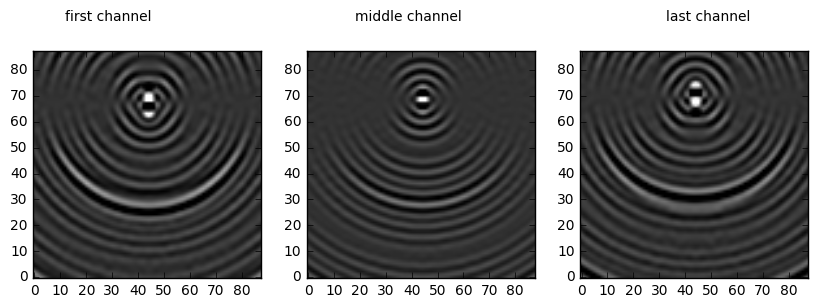

In [220]:
print '# Executing MIRIAD commands'
image='m_vs'
if os.path.exists(image): shutil.rmtree(image)
run_invert=Run('invert vis=%sl map=%s imsize=512 cell=5 slop=1 robust=0'%(simuv,image))
run_fits=Run('fits in=%s op=xyout out=%s.fits'%(image,image))
print '# Done'

f=fits.open('%s.fits'%image)
cube=f[0].data[0]
f.close()

ppl.figure(figsize=(10,5))
#ppl.subplots_adjust(wspace=0.4,hspace=0.45)
ppl.subplot(131)
ppl.imshow(cube[0,212+100:300+100,212:300],origin='lower',cmap='gray',vmin=-0.05,vmax=0.2)
ppl.subplot(132)
ppl.imshow(cube[128,212+100:300+100,212:300],origin='lower',cmap='gray',vmin=-0.05,vmax=0.2)
ppl.subplot(133)
ppl.imshow(cube[-1,212+100:300+100,212:300],origin='lower',cmap='gray',vmin=-0.05,vmax=0.2)
ppl.figtext(0.20,0.8,'first channel',ha='center')
ppl.figtext(0.50,0.8,'middle channel',ha='center')
ppl.figtext(0.80,0.8,'last channel',ha='center')
ppl.show()

### 3.3. Visibility-based continuum subtraction and calibration errors

One significant advantage of this method is that it is insensitive to frequency-independent gain calibration errors. That is, once a good bandpass calibration has been achieved, the method works equally well regardless of whether a frequency-independent, time-dependent gain calibration has been performed. The reason is that visbility-based continuum subtraction works on each visibility spectrum (i.e.g, fixed time) independently. For each of these spectra the application of a frequency-independent gain calibration does not change the spectral shape and, therefore, the order of the polynomial required for a good fit of the coninuum.

Of course, if the method is used on a dataset with significant gain calibration errors the resulting spectral line cube will show artefacts at the channels with significant emission/absorption. The advantage is that the level of those artefacts will depend on the brightness of the line signal and not of the continuum. This is important since the line signal is typically much fainter than the continuum one.

## 4. Model-based continuum subtraction

### 4.1. Basic method

Both the cube-based and visibility-based continuum subctraction methods described above suffer from limitations that are related to chromatic effects. In the case of the cube-based continuum subtraction the issue is that the PSF changes with frequency and, therefore, the continuum spectral shape at the position of a source's sidelobes is complex and difficult to subtract. In the case of the visbility-based continuum subtraction the issue is that the shape of the visibility spectrum of a source depends on the distance of the source from the phase centre -- and when the latter is significant continuum subtraction is challenging.

This alternative method of performing a model-based continuum subtraction gets around these chromatic issues. It consists of modelling the radio continuum sky and subtract the Fourier transform of the model from the visibilities. The operation of Fourier transform is done for each channel in the visibility dataset, and this takes properly into account all chromatic effects.

Compared to cube- and visibility-based continuum subtraction this method is slower, especially if working on a large bandwidth as this requires modelling and Fourier transforming not only the flux density but also the spectral shape of each source on the sky. For this reason in many cases it is preferable to use the other methods as long as they give results of sufficient quality.

To illustrate this method we consider a model which combines the two models used above. It consists of a point source at the phase centre and another one with half the flux 10 arcmin north of the phase centre. As above we do not include any noise in the simulations.

In [235]:
print '# Executing MIRIAD commands'
simuv='sim03.uv'
image='m03'
beam='b03'
image_noscale='m03_ns'
if os.path.exists(simuv): shutil.rmtree(simuv)
if os.path.exists(image): shutil.rmtree(image)
if os.path.exists(beam): shutil.rmtree(beam)
if os.path.exists(image_noscale): shutil.rmtree(image_noscale)
run_uvgen=Run('uvgen source=pointsource03.txt ant=ew_layout.txt baseunit=-51.0204 radec=19:39:25.0,-83:42:46 freq=1.4,0 corr=256,1,0,100 out=%s harange=-6,6,0.016667 systemp=0 lat=-30.7 jyperk=19.28'%(simuv))
run_invert=Run('invert vis=%s map=%s beam=%s imsize=512 cell=5 slop=1 robust=0'%(simuv,image,beam))
run_regrid=Run('regrid in=%s out=%s options=noscale'%(image,image_noscale))
run_fits=Run('fits in=%s op=xyout out=%s.fits'%(image_noscale,image_noscale))
print '# Done'

# Executing MIRIAD commands
uvgen source=pointsource03.txt ant=ew_layout.txt baseunit=-51.0204 radec=19:39:25.0,-83:42:46 freq=1.4,0 corr=256,1,0,100 out=sim03.uv harange=-6,6,0.016667 systemp=0 lat=-30.7 jyperk=19.28
invert vis=sim03.uv map=m03 beam=b03 imsize=512 cell=5 slop=1 robust=0
regrid in=m03 out=m03_ns options=noscale
fits in=m03_ns op=xyout out=m03_ns.fits
# Done


We can image these data to show, once again, the chromatic effect of the sidelobe movement as a function of frequency, which complicates cube-based continuum subtraction.

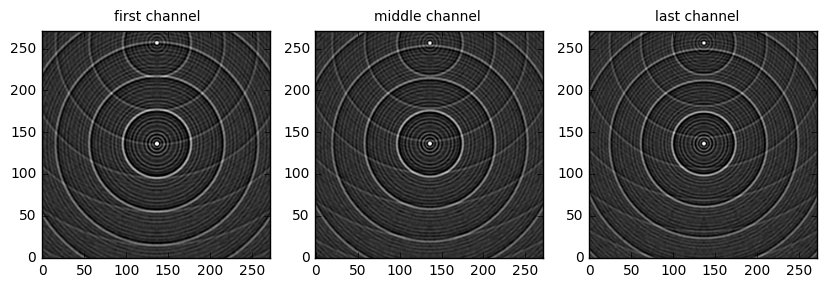

In [246]:
f=fits.open('%s.fits'%image_noscale)
cube=f[0].data[0]
f.close()

ppl.figure(figsize=(10,5))
#ppl.subplots_adjust(wspace=0.4,hspace=0.45)
ppl.subplot(131)
ppl.imshow(cube[0,120:392,120:392],origin='lower',cmap='gray',vmin=-0.05,vmax=0.2)
ppl.subplot(132)
ppl.imshow(cube[128,120:392,120:392],origin='lower',cmap='gray',vmin=-0.05,vmax=0.2)
ppl.subplot(133)
ppl.imshow(cube[-1,120:392,120:392],origin='lower',cmap='gray',vmin=-0.05,vmax=0.2)
ppl.figtext(0.24,0.76,'first channel',ha='center')
ppl.figtext(0.51,0.76,'middle channel',ha='center')
ppl.figtext(0.78,0.76,'last channel',ha='center')
ppl.show()

Furthermore, we can see also for this new simulation the rapid variation of the visibility on long baselines, which complicates visibility-based continuum subtraction.

In [252]:
print '# Executing MIRIAD commands'
run_uvspec=Run('uvspec vis=%s device=sim03_spec2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-2,2'%(simuv))
print '# Done'

# Executing MIRIAD commands
uvspec vis=sim03.uv device=sim03_spec2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-2,2
# Done


2km baseline <img src="sim03_spec2km.png" width="400">

In what follows we show that the model-based continuum subtraction gets around these issues. We will use CLEAN to make a frequency-independent model of the continuum sky, Fourier transform it and subtract it from the visibilities.

## 5. Combining the above approaches

E.g., subtract a model, especially for distant sources, then UVLIN or IMLIN. Add Jing's method.

### Bibliography

<a href="http://adsabs.harvard.edu/abs/1992A%26A...258..583C">Cornwell, Uson & Addad 1992, A&A, 258, 583</a>

<a href="http://adsabs.harvard.edu/abs/1999ASPC..180..229R">Rupen 1999, ASPC, 180, 229</a>

<a href="http://adsabs.harvard.edu/abs/1994A%26AS..107...55S">Salt 1994, A&AS, 107, 55</a>

<a href="http://adsabs.harvard.edu/abs/1983ApJ...267..528V">van Gorkom & Ekers 1983, ApJ, 267, 528</a>

<a href="http://adsabs.harvard.edu/abs/1986syim.conf..177V">van Gorkom & Ekers 1986, Synthesis imaging, 177</a>

<a href="http://adsabs.harvard.edu/abs/1989ASPC....6..341V">van Gorkom & Ekers 1989, ASPC, 6, 341</a>

<a href="http://adsabs.harvard.edu/abs/1990A%26A...239L...5V">van Langevelde & Cotton 1990, A&A, 239L, 5

<a href="http://adsabs.harvard.edu/abs/2015MNRAS.453.2399W">Wang et al. 2015, MNRAS, 453, 2399</a>

### Chapter Editors
* Name 1
* Name 2

#### Chapter Contributors

* Name 3 (**1.0**, **1.1**)
* Name 4 (**1.1**)

***

   * Next: [1.1 Somename 2](01_01_somename2.ipynb)
